# Глубокое обучение и вообще:  практическое домашнее задание 4

## Общая информация

__Дата выдачи:__ 21.05.2022

__Мягкий дедлайн:__ 23:59MSK 29.05.2022

__Жесткий дедлайн:__ 23:59MSK 05.06.2022

## О задании

Каждое из пяти заданий стоит два балла.

## Формат сдачи

Задания сдаются через google-форму. Она будет опубликована на [странице курса](https://github.com/FUlyankin/deep_learning_tf) и в канале. В форму необходимо загрузить ноутбук с выполенным заданием. Сам ноутбук называйте в формате hw-04-tf-Username.ipynb, где Username — ваши фамилия и имя.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

__Оценка:__ xx

In [ ]:
# Поставим недостающий пакет
!pip3 install sktime --ignore-installed

     |███████████████████▏            | 3.4 MB 37.4 MB/s eta 0:00:01

     |████████████████████████████████| 5.7 MB 37.4 MB/s 


     |███████████████▉                | 4.7 MB 107.9 MB/s eta 0:00:01

     |███████████████████████████     | 8.0 MB 107.9 MB/s eta 0:00:01

     |████████████████████████████████| 9.5 MB 107.9 MB/s 


     |████████████████████████████████| 22.3 MB 48.0 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 114.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 57.3 MB/s eta 0:00:01
     |████████████████████████████████| 818 kB 109.3 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 90.6 MB/s eta 0:00:01    |██▉                             | 2.2 MB 90.6 MB/s eta 0:00:01     |█████████                       | 7.1 MB 90.6 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 114.2 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 115.6 MB/s eta 0:00:01
     |████████████████████████████████| 28.5 MB 118.0 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 122.8 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 114.5 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' com

# Авокадо

Хорошо известно, что миллениалы любят тосты с авокадо. Хорошо известно, что миллениалы живут со своими родителями. На самом деле они не могут купить себе дом, потому что едят слишком много тостов с авокадо. Но надежда есть. Если нам удастся найти город с дешёвым авокадо, миллениалы смогут туда переехать и накопить денег на собственные квартиры. В этом задании мы этим и займёмся!

In [ ]:
import numpy as np
import pandas as pd

from scipy import stats 

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import seaborn as sns
%matplotlib inline

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

## Данные

Данные взяты [с соревнавания на kaggle.](https://www.kaggle.com/neuromusic/avocado-prices) В табличке ниже представлены месячные данные по розничной торговле авокадо:

* `Date` - дата наблюдения
* `AveragePrice` - средняя цена одного авокадо
* `Type` - обычный или органический
* `Year` - год
* `Region` - город или регион наблюдения

Кроме этих колонок есть ещё несколько технических, но они нас не будут интересовать. 

In [ ]:
dff = pd.read_csv('avocado_small.tsv', sep='\t', parse_dates=['Date']).set_index('Date')

# Периодичность данных - месячная 
dff.index = dff.index.to_period("M")

# будем смотреть только на тип organic 
dff = dff[dff.Type == 'organic'] 
print(dff.shape)
dff.head()

(2105, 4)


,AveragePrice,Region,Year,Type
Date,,,,
2015-12,1.84,Albany,2015,organic
2015-11,1.88,Albany,2015,organic
2015-10,1.98,Albany,2015,organic
2015-09,1.86,Albany,2015,organic
2015-08,2.00,Albany,2015,organic


Сразу же ответим на вопрос из шапки этой тетрадки и посмотрим как в разных городах цена на авокадо менялась год от года.

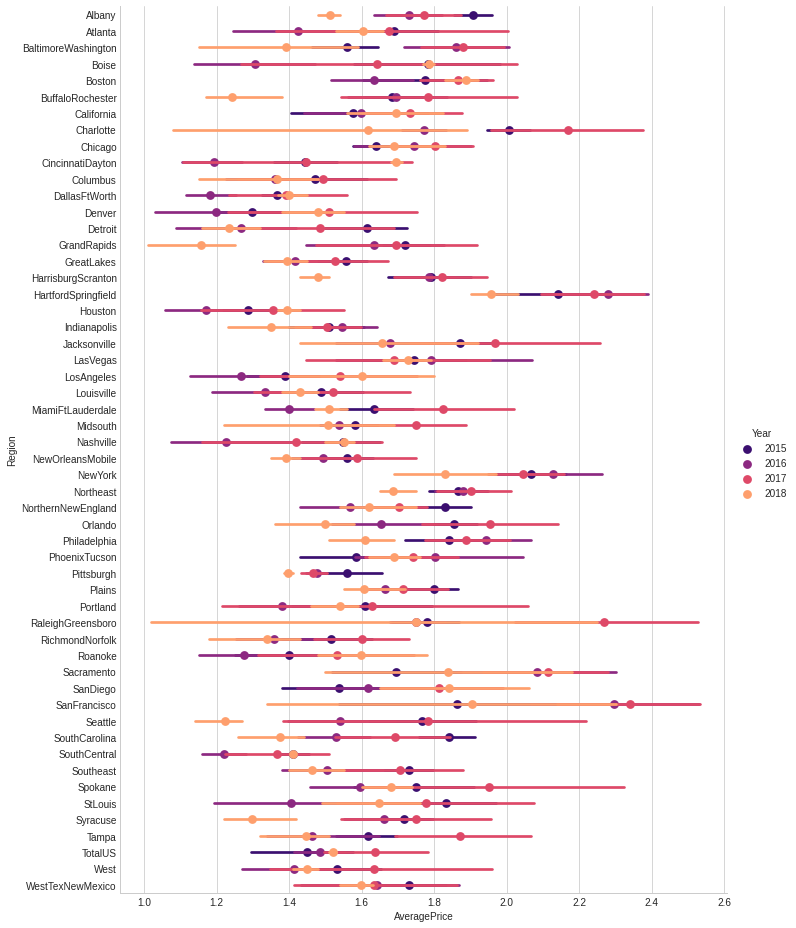

In [ ]:
sns.factorplot('AveragePrice', 'Region', data=dff, hue='Year',
                size=13, aspect=0.8, palette='magma', join=False);

Кажется, что Сан-Франциско точно не подходит. Судя по всему, миллениалов может спасти Хьюстон. 

In [ ]:
df = dff[['AveragePrice', 'Region']]
df.head()

,AveragePrice,Region
Date,,
2015-12,1.84,Albany
2015-11,1.88,Albany
2015-10,1.98,Albany
2015-09,1.86,Albany
2015-08,2.00,Albany


In [ ]:
df.index.unique().size # 39 уникальных точек (месячные данные)

39

In [ ]:
df.Region.unique().size # 54 города

54

## 1. Наивные прогнозы и кросс-валидация

Будем оценивать качество каждой модели с помощью кросс-валидации. Для кросс-валидации будем использовать класс [SlidingWindowSplitter,](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html#sktime.forecasting.model_selection.SlidingWindowSplitter) в рамках которого реализовано скользящее окно. В тестовой выборке будем держать три месяца.

In [ ]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

# параметры для кросс-валидации
window_length = 27                     # y_train.size
fh = ForecastingHorizon([1, 2, 3])     # максимум на 3 месяца вперёд
fh_length = len(fh)                    # даты для тестовой выборки

cv_window = SlidingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)

n_splits = cv_window.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Выглядеть наше разбиение будет вот таким образом. Голубое - обучающая выборка, оранжевое - тестовая. Найти код для строительства такой картинки можно [в документации.](https://github.com/alan-turing-institute/sktime/blob/master/examples/window_splitters.ipynb) Там же описано много других стратегий кросс-валидации, уже реализованных в рамках пакета. 

![](split.png)

Например, кросс-валидацию можно было бы сделать вот так.

In [ ]:
def mape(y_true, y_pred): 
    return np.abs((y_true - y_pred) / y_true)* 100

def cross_val_sccore(forecaster, y, cv=cv_window):
    M = [ ]

    for idx_train, idx_val in cv.split(y):
        
        y_tr = y[idx_train]
        y_val = y[idx_val]
        fh_val = ForecastingHorizon(y_val.index, is_relative=False)
        
        forecaster.fit(y_tr)

        y_pred = forecaster.predict(fh)
        
        M.append(mape(y_val, y_pred).values)
        
    return np.array(M)

model = ... # ваша модель
M = cross_val_sccore(model, y)
quality = M.mean(axis=0)
quality

array([11.08963133, 14.67886758, 14.90843752])

В векторе quality записано три различных значения MAPE нашей модели при прогнозировании на месяц, два и три вперёд. Бывает так, что одни модель хорошо прогнозируют в краткосрочном периоде, а другие хорошо в долгосрочном. Будем поддерживать три метрики MAPE посчитанные для каждого из периодов. 

__Задание 1:__ 

Возьмите ряд с ценами на авокадо для одного любого города.

- Оцените качество наивного прогноза для этого ряда. Лучший способ выберите с помощью [ForecastingGridSearchCV.](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.ForecastingGridSearchCV.html)
- Выберите свою любимую модель (ARIMA/TBATS/ETS/Prophet и тп), попробуйте построить прогнозы с помощью неё. Гиперпараметры подберите с помощью ForecastingGridSearchCV

Обратите внимание, что я хочу увидеть в этом задании в качестве ответа три метрики качества, а не одну. Подбирать гиперпараметры можно и по одной цифре. 

In [ ]:
# ваш код 

__Задание 2:__

Соберите рекуррентную нейросетку и попытайтесь побить ей модели из предыдущего пункта. Все эксперименты залогируйте. Качество оценивайте на кросс-валидации. Один ряд будет не очень большим и вы не упорететьсь со временем работы сетки. Понятное дело, что на длинных рядах так делать не стоит.

In [ ]:
# ваш код 

__Задание 3:__ Попробуем поработать с нашими данными в другом разрезе. Отделите от каждого ряда три последних месяца в тестовую выборку. Обучите свою любимую модель из первого задания для каждого ряда. Нарисуйте ряд, для которого качество на тестовой выборке получилось самым плохим. Нарисуйте ряд с самым хорошим качеством. Как думаете, почему так вышло?

In [ ]:
# ваш код 

__Задание 4:__ Сделайте ровно то же самое со своей нейронной сеткой.

In [ ]:
# ваш код 

__Задание 5:__ Для каждого города у вас есть MAPE рассчитанное для трёх последних месяцев для двух моделей. Усредните качество по городам. Какая из моделей работает лучше? 

In [ ]:
# ваш код 